<a href="https://colab.research.google.com/github/TranDucLongAIDHSPKTHY/DemoMovies/blob/main/Recommendation_systems_for_Movies_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [443]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [444]:
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [445]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [446]:
ratings = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/ratings_small.csv')
movies = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/movies_small.csv')
credits = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/credits_small.csv')

In [447]:
# Kết hợp dữ liệu movies và credits dựa trên cột "id" và "movie_id"
merged = pd.merge(movies, credits, left_on='id', right_on='movie_id')

In [448]:
# Tạo từ điển chứa movie_id và tiêu đề của phim từ dataset đã kết hợp
movie_id_to_title = dict(zip(merged['id'], merged['title_x']))

In [449]:
# Chỉ giữ lại các movie_id trong file ratings có trong dataset đã kết hợp
matched_ratings = ratings[ratings['movieId'].isin(merged['id'])].copy()

In [452]:
# Trích xuất các user_id và movie_id duy nhất
user_ids = matched_ratings['userId'].unique().tolist()
movie_ids = matched_ratings['movieId'].unique().tolist()

In [453]:
# Đánh chỉ số cho user_id và movie_id
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [454]:
# Thay thế user_id và movie_id bằng các chỉ số
matched_ratings['userId'] = matched_ratings['userId'].map(user_id_to_index)
matched_ratings['movieId'] = matched_ratings['movieId'].map(movie_id_to_index)

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-456-fc62f7211199>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




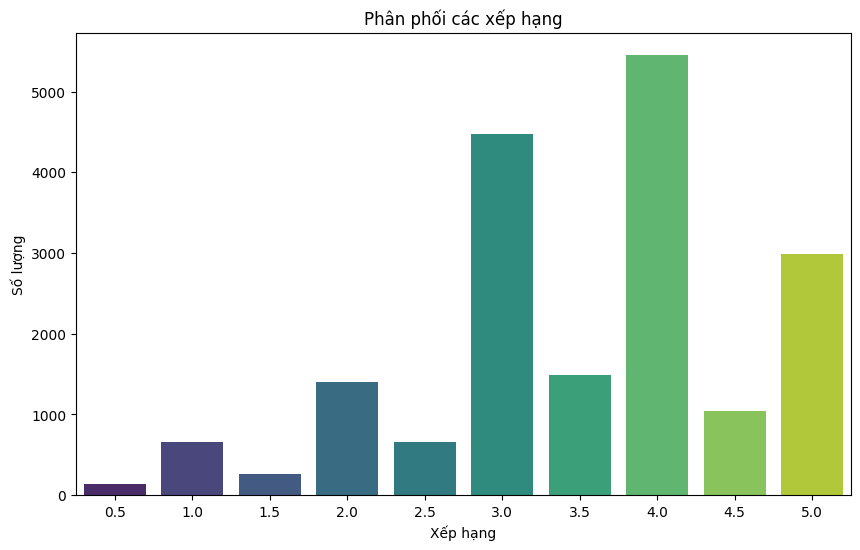

In [456]:
#Biểu đồ phân phối xếp hạng của các bộ phim
plt.figure(figsize=(10, 6))
sns.countplot(data=matched_ratings, x='rating', palette='viridis')
plt.title('Phân phối các xếp hạng')
plt.xlabel('Xếp hạng')
plt.ylabel('Số lượng')
plt.show()

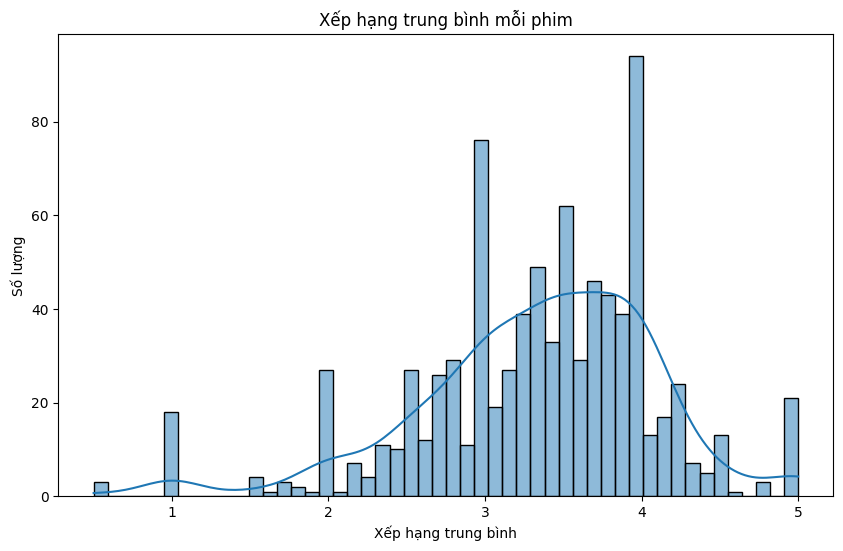

In [457]:
# Tính trung bình xếp hạng cho mỗi phim
average_rating_per_movie = matched_ratings.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_movie, bins=50, kde=True)
plt.title('Xếp hạng trung bình mỗi phim')
plt.xlabel('Xếp hạng trung bình')
plt.ylabel('Số lượng')
plt.show()

In [458]:
train, test = train_test_split(matched_ratings, test_size=0.2, random_state=42)

In [459]:
# Định nghĩa dataset cho PyTorch
class RatingsDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = self.ratings.iloc[idx, 0]  # Lấy user
        movie = self.ratings.iloc[idx, 1]  # Lấy movie
        rating = self.ratings.iloc[idx, 2]  # Lấy rating
        return torch.tensor(user), torch.tensor(movie), torch.tensor(rating, dtype=torch.float32)

In [461]:
# Tạo dataset cho train và test
train_dataset = RatingsDataset(train)
test_dataset = RatingsDataset(test)

In [462]:
# Tạo DataLoader để lấy các batch dữ liệu
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [463]:
# Định nghĩa mô hình mạng nơ-ron NFC (Neural Fully Connected)
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=100):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)  # Embedding cho user
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)  # Embedding cho movie
        self.fc1 = nn.Linear(embedding_size * 2, 256)  # Lớp fully connected đầu tiên
        self.fc2 = nn.Linear(256, 128)  # Lớp fully connected thứ hai
        self.fc3 = nn.Linear(128, 64)  # Lớp fully connected thứ ba
        self.fc4 = nn.Linear(64, 1)  # Lớp fully connected cuối cùng

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)  # Biểu diễn embedding cho user
        movie_embedded = self.movie_embedding(movie)  # Biểu diễn embedding cho movie
        x = torch.cat([user_embedded, movie_embedded], dim=1)  # Kết hợp embedding của user và movie
        x = torch.relu(self.fc1(x))  # Kích hoạt ReLU sau lớp fully connected 1
        x = torch.relu(self.fc2(x))  # Kích hoạt ReLU sau lớp fully connected 2
        x = torch.relu(self.fc3(x))  # Kích hoạt ReLU sau lớp fully connected 3
        x = self.fc4(x)  # Dự đoán xếp hạng
        return x

In [464]:
# Khởi tạo mô hình với số lượng user và movie
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 100

In [465]:
# Tạo mô hình RecommenderNet
model = RecommenderNet(num_users, num_movies, embedding_size)
criterion = nn.MSELoss()  # Hàm loss sử dụng MSE
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Sử dụng optimizer Adam

In [467]:
# Huấn luyện mô hình
num_epochs = 10

In [468]:
for epoch in range(num_epochs):
    model.train()  # Đặt chế độ training cho mô hình
    train_loss = 0
    for user, movie, rating in train_loader:
        optimizer.zero_grad()  # Đặt lại gradient về 0
        output = model(user, movie)  # Dự đoán xếp hạng
        loss = criterion(output, rating.view(-1, 1))  # Tính toán loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Cập nhật các tham số
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Tính trung bình loss cho mỗi epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

Epoch 1/10, Training Loss: 1.4253
Epoch 2/10, Training Loss: 0.8241
Epoch 3/10, Training Loss: 0.7321
Epoch 4/10, Training Loss: 0.6711
Epoch 5/10, Training Loss: 0.6147
Epoch 6/10, Training Loss: 0.5657
Epoch 7/10, Training Loss: 0.5268
Epoch 8/10, Training Loss: 0.4978
Epoch 9/10, Training Loss: 0.4530
Epoch 10/10, Training Loss: 0.4171


In [469]:
# Lưu mô hình sau khi huấn luyện
torch.save(model.state_dict(), 'model_weights.pth')

In [470]:
# Tải mô hình đã lưu
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Đặt mô hình vào chế độ evaluation

<ipython-input-470-f239c780f362>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



RecommenderNet(
  (user_embedding): Embedding(670, 100)
  (movie_embedding): Embedding(857, 100)
  (fc1): Linear(in_features=200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [474]:
# Hàm gợi ý phim cho một người dùng cụ thể
def recommend_movies(user_id, num_recommendations=10):
    user_idx = user_id_to_index[user_id]  # Lấy chỉ số của user
    user_tensor = torch.tensor([user_idx] * num_movies)  # Tạo tensor user
    movie_tensor = torch.tensor(np.arange(num_movies))  # Tạo tensor movie

    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, movie_tensor).numpy().flatten()  # Dự đoán điểm cho từng movie

    top_movie_indices = scores.argsort()[-num_recommendations:][::-1]  # Lấy các movie có điểm cao nhất
    recommended_movie_titles = [movie_id_to_title.get(movie_ids[i], "Unknown") for i in top_movie_indices]

    return recommended_movie_titles

In [475]:
# Ví dụ gợi ý phim cho user_id = 10
user_id = 10
recommended_movies = recommend_movies(user_id)
print("Các phim được gợi ý:", recommended_movies)

Các phim được gợi ý: ['Bowling for Columbine', 'Match Point', 'The Hunt for Red October', 'Mission: Impossible', 'Orgazmo', 'Galaxy Quest', 'You, Me and Dupree', 'Aliens', 'Akira', 'License to Wed']


In [478]:
# Đánh giá mô hình bằng các chỉ số RMSE và MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for user, movie, rating in test_loader:
        output = model(user, movie)  # Dự đoán xếp hạng
        predictions.extend(output.numpy().flatten())  # Lưu lại dự đoán
        actuals.extend(rating.numpy().flatten())  # Lưu lại giá trị thực

In [479]:
# Tính toán RMSE và MAE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)

In [480]:
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.9859734177589417
MAE: 0.7653394937515259


In [481]:
import numpy as np
import torch

def recommend_movies_for_user(user_id, num_recommendations=50):
    """
    Hàm gợi ý phim cho một người dùng cụ thể.

    Args:
        user_id: ID của người dùng.
        num_recommendations: Số lượng phim được gợi ý.

    Returns:
        Một danh sách các tựa phim được gợi ý.
    """

    if user_id not in user_id_to_index:
        print(f"Người dùng có ID {user_id} không tồn tại trong tập dữ liệu.")
        return []

    user_idx = user_id_to_index[user_id]
    user_tensor = torch.tensor([user_idx] * num_movies)
    movie_tensor = torch.tensor(np.arange(num_movies))

    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, movie_tensor).numpy().flatten()

    top_movie_indices = scores.argsort()[-num_recommendations:][::-1]
    recommended_movie_titles = [movie_id_to_title.get(movie_ids[i], "Unknown") for i in top_movie_indices]

    return recommended_movie_titles

# Ví dụ sử dụng hàm gợi ý phim
user_id_to_recommend = 1  # Thay đổi ID người dùng ở đây
recommendations = recommend_movies_for_user(user_id_to_recommend)
print(f"Các phim được gợi ý cho người dùng {user_id_to_recommend}:")
for movie in recommendations:
    print(f"- {movie}")


Các phim được gợi ý cho người dùng 1:
- Mission: Impossible
- Bowling for Columbine
- Along Came a Spider
- On Her Majesty's Secret Service
- Crank
- Flags of Our Fathers
- The Thirteenth Floor
- Team America: World Police
- Beverly Hills Cop III
- Open Season
- Terminator 3: Rise of the Machines
- The Mask
- Arlington Road
- Closer
- The Elephant Man
- Raiders of the Lost Ark
- Speed Racer
- The Legend of Suriyothai
- The Brothers Grimm
- License to Wed
- Army of Darkness
- Captain America: The First Avenger
- Gremlins 2: The New Batch
- Cold Mountain
- An Unfinished Life
- JFK
- Love in the Time of Cholera
- Dawn of the Dead
- Mystic River
- Aliens
- Akira
- Beetlejuice
- Knocked Up
- Pandora's Box
- Miss Congeniality
- A Christmas Story
- The Thomas Crown Affair
- The Green Mile
- Orgazmo
- Match Point
- Dear Frankie
- Thumbsucker
- Sunshine
- Young Frankenstein
- Solaris
- I, Robot
- The Shipping News
- Rocky Balboa
- The Good Thief
- Memoirs of a Geisha


In [482]:
# Hàm tính Precision@K và Recall@K
def precision_at_k(predictions, ground_truth, k):
    top_k_predictions = predictions.argsort()[-k:][::-1]  # Lấy k dự đoán hàng đầu
    relevant_items = ground_truth.argsort()[-k:][::-1]  # Lấy k item thực sự
    intersection = np.intersect1d(top_k_predictions, relevant_items)  # Lấy item đúng
    return len(intersection) / k

def recall_at_k(predictions, ground_truth, k):
    top_k_predictions = predictions.argsort()[-k:][::-1]  # Lấy k dự đoán hàng đầu
    relevant_items = ground_truth.argsort()[-k:][::-1]  # Lấy k item thực sự
    intersection = np.intersect1d(top_k_predictions, relevant_items)  # Lấy item đúng
    return len(intersection) / len(relevant_items)

In [483]:
k = 50
precision_scores = []
recall_scores = []

In [484]:
model.eval()
with torch.no_grad():
    for user, movie, rating in test_loader:
        output = model(user, movie).numpy().flatten()
        precision = precision_at_k(output, rating.numpy().flatten(), k)
        recall = recall_at_k(output, rating.numpy().flatten(), k)
        precision_scores.append(precision)
        recall_scores.append(recall)

average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

In [345]:
print(f'Precision@{k}: {average_precision}')
print(f'Recall@{k}: {average_recall}')


Precision@50: 0.5459999999999999
Recall@50: 0.5773333333333334
